# Data Analysis and Mining: First Project

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

#import ipywidgets  #???

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import scipy
import pylab
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Reading the data
df = pd.read_csv('CSM dataset.csv', sep=';')
df.head()

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,"6,3",8,9130,4000000,45.0,1,0,3280543,4632,425,636,1120000.0
1,22 Jump Street,2014,"7,1",1,192000000,50000000,3306.0,2,2,583289,3465,61,186,12350000.0
2,3 Days to Kill,2014,"6,2",1,30700000,28000000,2872.0,1,0,304861,328,34,47,483000.0
3,300: Rise of an Empire,2014,"6,3",1,106000000,110000000,3470.0,2,0,452917,2429,132,590,568000.0
4,A Haunted House 2,2014,"4,7",8,17300000,3500000,2310.0,2,0,3145573,12163,610,1082,1923800.0


## Preprocessing the data and EDA

In [5]:
# We are working only with the entries that don't have missing values
df.dropna(axis=0, inplace = True)
df.reset_index(drop=True, inplace=True)

# Remove duplicates from the dataset
df.drop_duplicates(inplace=True)

print("After considering only movies which have all of the desired information and removing duplicates, we are left with " + str(df.shape[0]) +
      " rows (entries) and " + str(df.shape[1]) + " columns (features)")

After considering only movies which have all of the desired information and removing duplicates, we are left with 187 rows (entries) and 14 columns (features)


In [262]:
df.head()

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.3,8,9130,4000000.0,45,1,0,3280543,4632,425,636,1120000
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306,2,2,583289,3465,61,186,12350000
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872,1,0,304861,328,34,47,483000
3,300: Rise of an Empire,2014,6.3,1,106000000,110000000.0,3470,2,0,452917,2429,132,590,568000
4,A Haunted House 2,2014,4.7,8,17300000,3500000.0,2310,2,0,3145573,12163,610,1082,1923800


It is now essential to check the data types of the features we will be working with.

In [263]:
df.dtypes.to_frame().T

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,string,category,float64,category,int64,float64,int32,int64,int64,int64,int64,int64,int64,int32


Some features are not assigned to a proper datatype. The following adjustments are needed:
- 'Movie', as a name of the movie, can have a type *string*
- 'Ratings' column contains numbers from 0 to 10, usually with some decimal points, so should have type *float*
- 'Budget' should have a *float* type as well
- 'Screens' can be reduced to *int* since the number of movie projections is always an integer
- 'Aggregate Followers' will be reduced to *int* likewise. There can't be 0.4 of a follower on social media

There are also categorical features such as 'Year' and 'Genre' that are currently assinged a numerical type.

</br>

Moreover, we noticed the decimal point in 'Ratings' column is expressed with a comma *',00'* instead of the standard *'.00'*. For simplicity and consistency with the usual format *'.00'* we are going to ensure every *float* is expressed that way.

In [264]:
# Ensuring the proper data types

df['Movie'] = df['Movie'].astype("string")
df['Ratings'] = df['Ratings'].astype("string").str.replace(',', '.').astype(float)
df['Budget'] = df['Budget'].astype("string").str.replace(',', '.').astype(float)
df['Screens'] = df['Screens'].astype(int)
df['Aggregate Followers'] = df['Aggregate Followers'].astype(int)

df['Year'] = df['Year'].astype('category')
df['Genre'] = df['Genre'].astype('category')

display(df.dtypes.to_frame().T)
df.head()

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,string,category,float64,category,int64,float64,int32,int64,int64,int64,int64,int64,int64,int32


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.3,8,9130,4000000.0,45,1,0,3280543,4632,425,636,1120000
1,22 Jump Street,2014,7.1,1,192000000,50000000.0,3306,2,2,583289,3465,61,186,12350000
2,3 Days to Kill,2014,6.2,1,30700000,28000000.0,2872,1,0,304861,328,34,47,483000
3,300: Rise of an Empire,2014,6.3,1,106000000,110000000.0,3470,2,0,452917,2429,132,590,568000
4,A Haunted House 2,2014,4.7,8,17300000,3500000.0,2310,2,0,3145573,12163,610,1082,1923800


We begin the exploration of the data with some basic statistics

In [265]:
statistics = pd.concat([round(df.mean(numeric_only=True), 1),
                        round(df.min(numeric_only=True), 1),
                        round(df.max(numeric_only=True), 1),
                        round(df.std(numeric_only=True), 1),
                        round(df.median(numeric_only=True), 1)],
                       axis=1)

statistics = statistics.set_axis(['Mean', 'Min', 'Max', 'Std', 'Median'], axis=1)
statistics.T

,Ratings,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
Mean,6.4,77646943.9,53844373.2,2334.3,1.4,2.8,3931376.8,12994.0,718.2,1828.9,3145584.8
Min,3.1,2470.0,70000.0,2.0,1.0,-38.0,698.0,1.0,0.0,0.0,1066.0
Max,8.7,643000000.0,250000000.0,4324.0,7.0,29.0,32626778.0,370552.0,13960.0,38363.0,31030000.0
Std,1.0,93899208.1,57100688.8,1441.3,1.1,7.2,4744583.8,28912.9,1315.2,3478.1,4974639.3
Median,6.5,47000000.0,30000000.0,2872.0,1.0,0.0,2554307.0,6772.0,378.0,885.0,1174806.0


In order to gain more insight into the values such as 'Year', 'Genre' and 'Sequel', let's see all the possible values and count the occurrences.

In [266]:
# How many distinct values are in each of these variables

pos_values = pd.DataFrame(pd.concat([df['Year'], df['Genre'], df['Sequel']], axis=1).nunique())
pos_values = pos_values.set_axis(["Possible Values"], axis=1)
pos_values.T

,Year,Genre,Sequel
Possible Values,2,10,7


In [267]:
# How many times each value appears in the column of our dataframe

for i in ['Year', 'Genre', 'Sequel']:
    values, counts = np.unique(df[i], return_counts=True)
    df_counts = pd.DataFrame(counts, columns=['Appearances'], index=values)
    df_counts.index.name = i
    display(df_counts.T)

Year,2014,2015
Appearances,133,54


Genre,1,2,3,6,7,8,9,10,12,15
Appearances,55,11,37,2,1,43,10,9,12,7


Sequel,1,2,3,4,5,6,7
Appearances,145,24,8,3,4,1,2


Now we can look at distributions of each feature as well as 2D scatter plots and correlations between plotted variables.

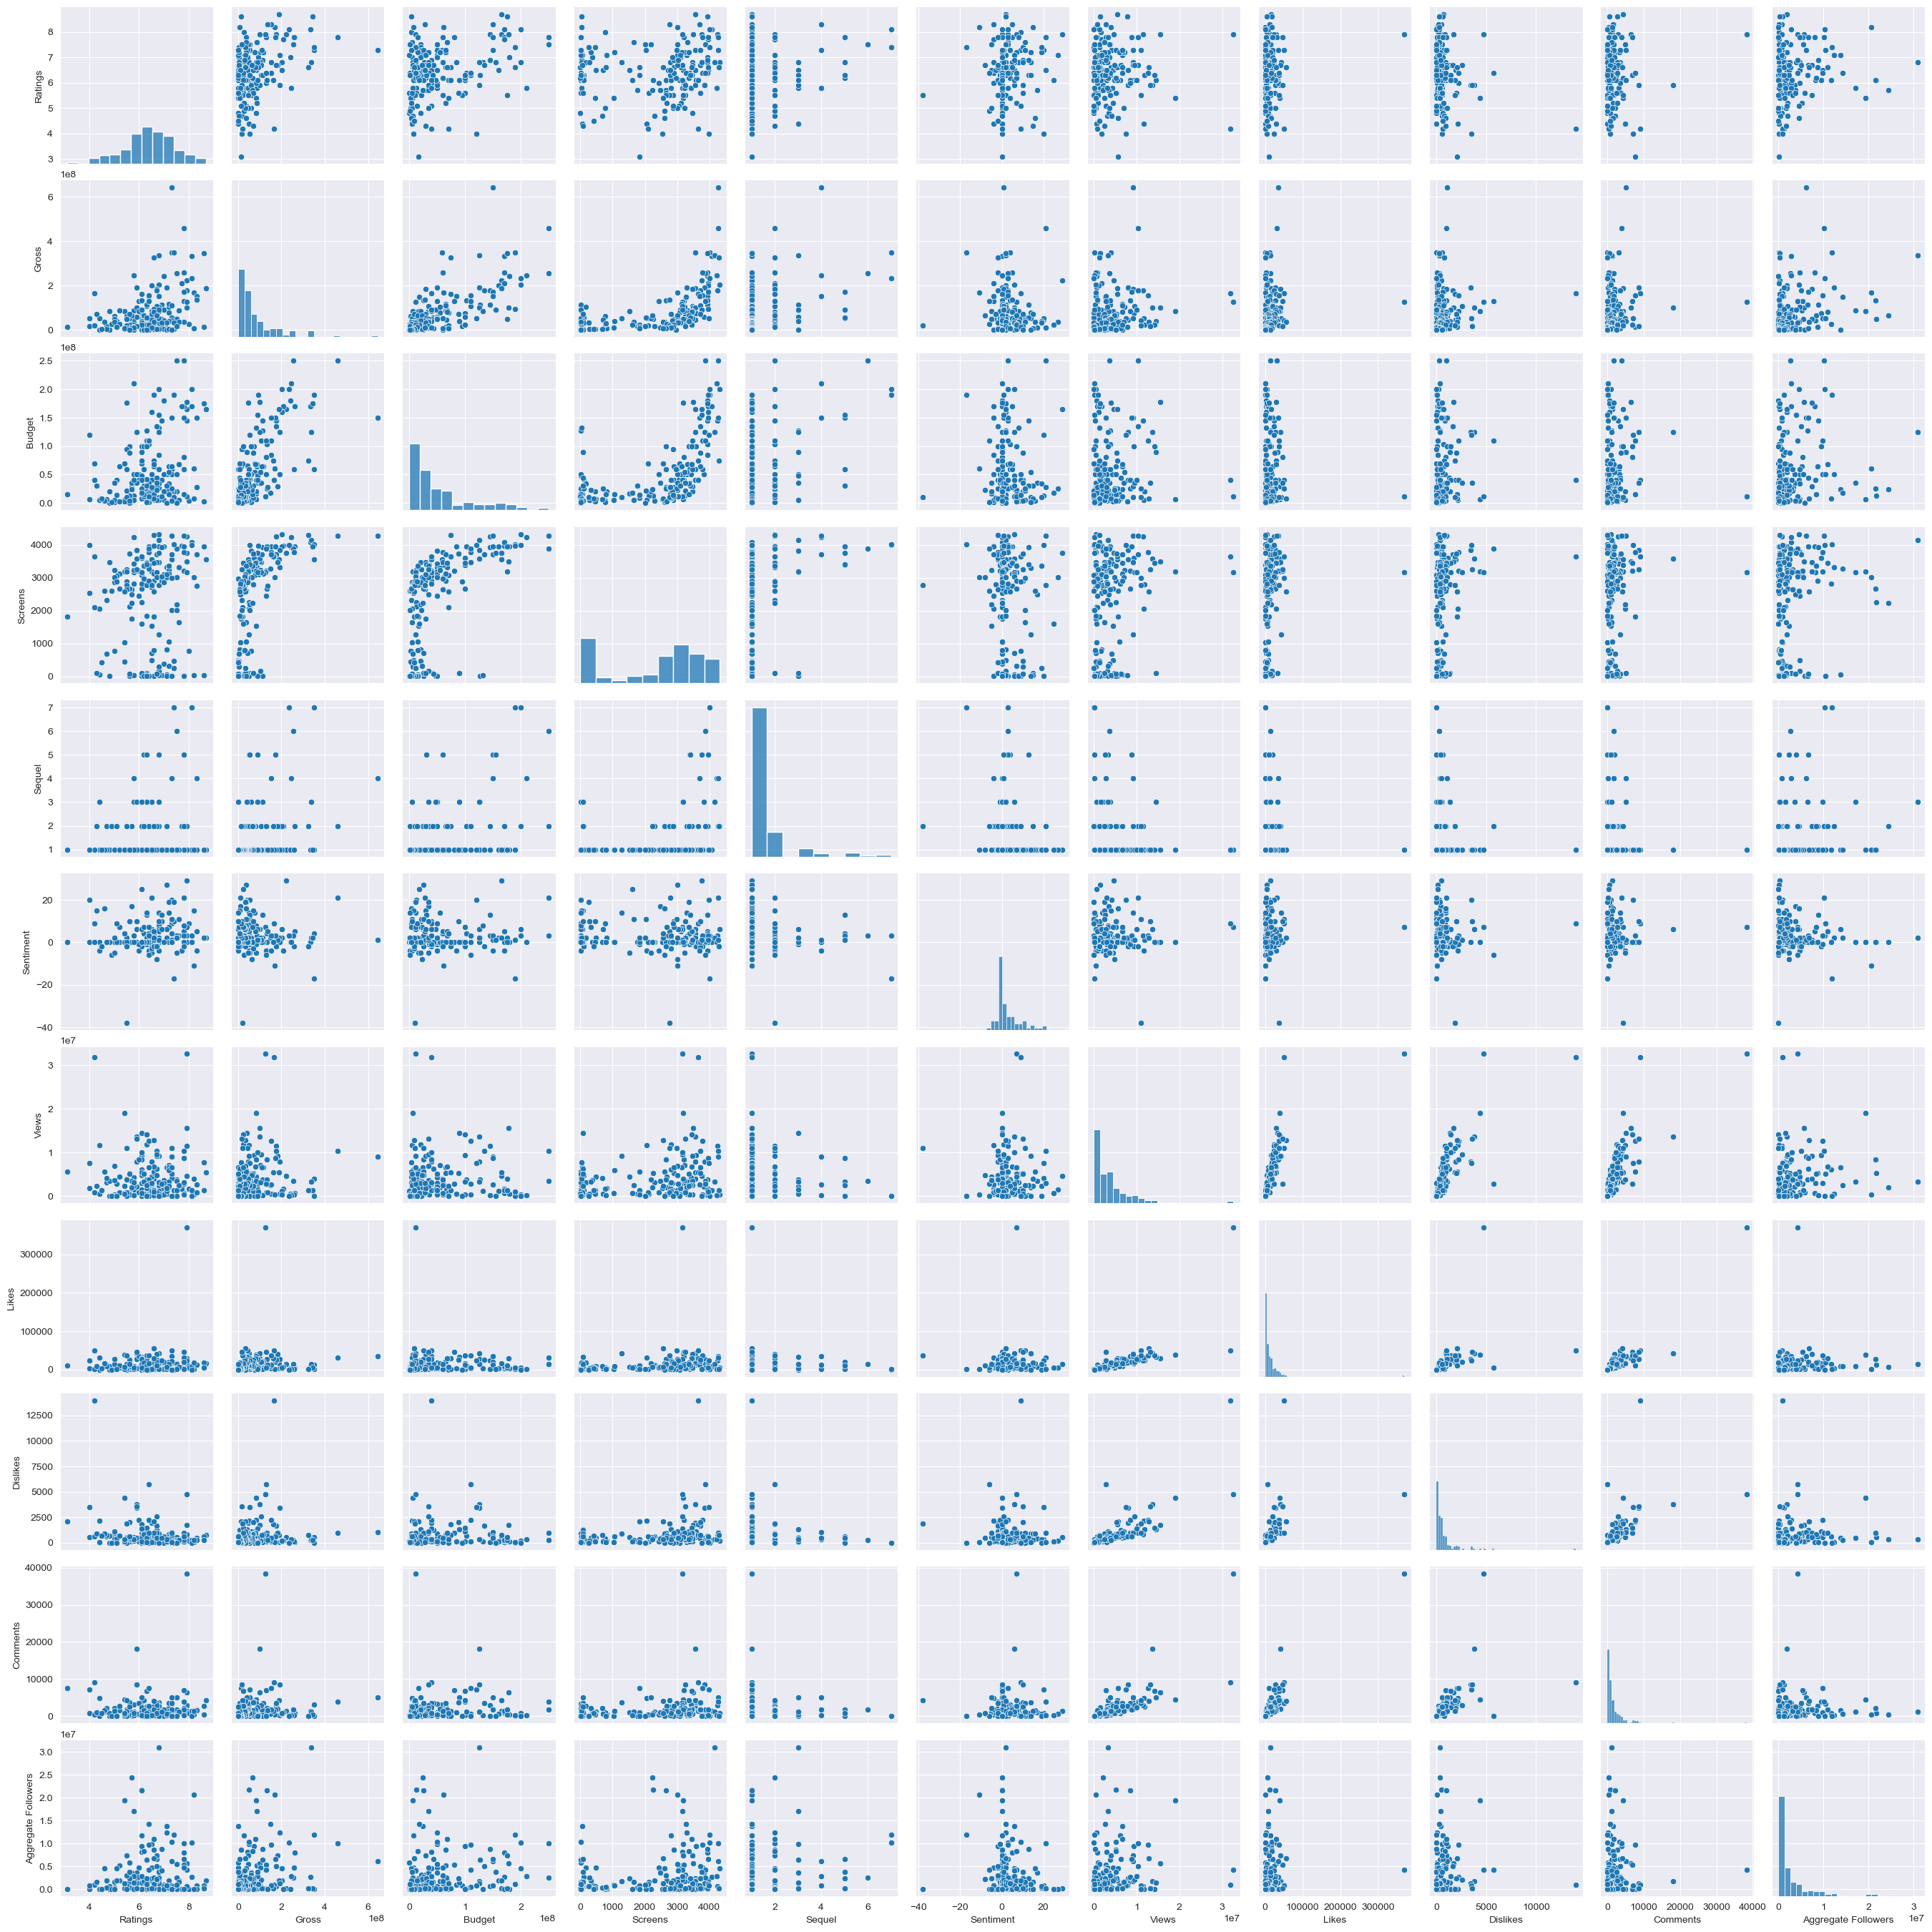

In [268]:
sns.pairplot(df.drop(columns = ["Movie"], inplace=False));

C:\Users\Robert\AppData\Local\Temp\ipykernel_19988\607727485.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



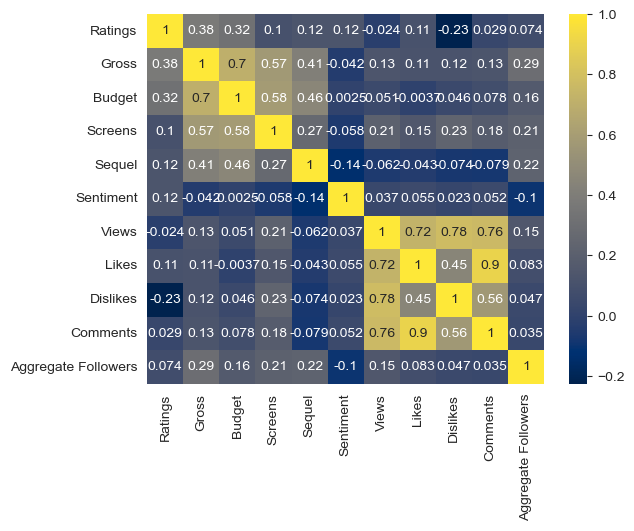

In [269]:
corr_matrix = df.drop(columns = ["Movie"], inplace=False).corr()
sns.heatmap(corr_matrix, annot=True, cmap='cividis');

#### Propositions of features for building a linear regression model: Views ~ Likes or Comments ~ Views

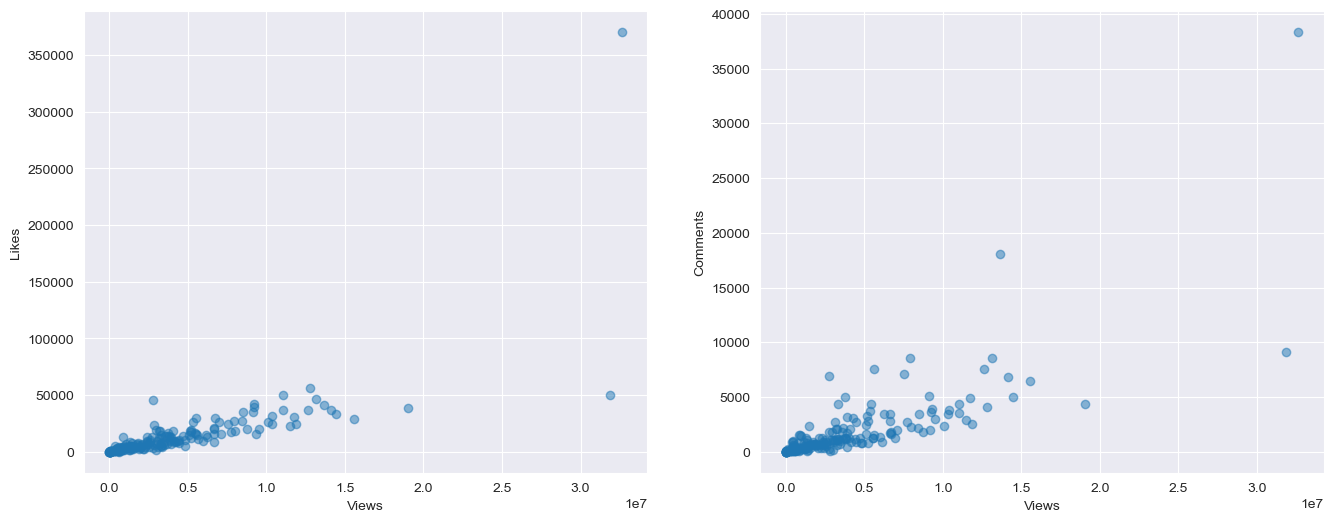

In [270]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

sns.regplot(x = df['Views'], y = df['Likes'], fit_reg=False, ax = axes[0], lowess=True, scatter_kws={'alpha':0.5})
sns.regplot(x = df['Views'], y = df['Comments'], fit_reg=False, ax = axes[1], lowess=True, scatter_kws={'alpha':0.5});


The linear relationship between the variables seems stronger in the first scatterplot. There is only one big outlier (near the value 30M Views). Possibly another point with similar number of views can be regarder as an outlier but it isn't that clear without drawing the regression line. We can also see that the smaller our independent variable gets, the linear relationship seems to be stronger in both cases.

We can try to examine this observation by plotting what percentage of the number of Views is the number of Likes for a particular movie. That should give us more insight into the area near the origin of the previous plot as well as reduce the impact of the outlier that stands out (which is a highly viewed and well recieved movie). We suspect the points on the plot of Likes/Views to Views may accumulate in an interval around a horizontal line.

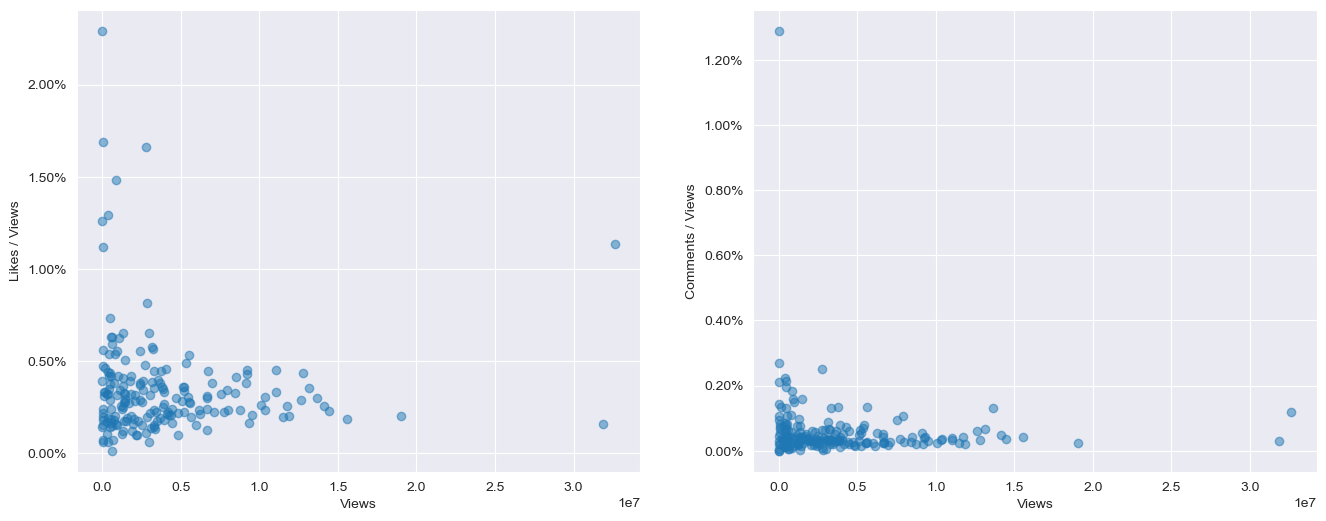

In [271]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

sns.regplot(x = df['Views'], y = df['Likes']/df['Views'], fit_reg=False, ax = axes[0], lowess=True, scatter_kws={'alpha':0.5})
sns.regplot(x = df['Views'], y = df['Comments']/df['Views'], fit_reg=False, ax = axes[1], lowess=True, scatter_kws={'alpha':0.5});

axes[0].set_ylabel("Likes / Views")
axes[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))

axes[1].set_ylabel("Comments / Views")
axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

Most of the data from the first plot follows our claim, setting the Likes interval from 0.1% to 0.5% of the Viewership. The mean of the percentage seems to be around 0.25% but we'll assess this value better during regression analysis which we are going to perform soon.

The situation on the second plot is much more complicated since the points accumulate strongly near the x=0 line so we should make this plot in a different scale, ignoring the outlier that interferes with the y-axis units. However, in this case, it would be best to estimate the slope of the regression line to get the desired value.

#### From now on we are going to perform the linear regression analysis on features 'Likes' and 'Views'.

Estimated coefficients of the regression line: 
Slope:  0.004407 
Intercept:  -4331.0


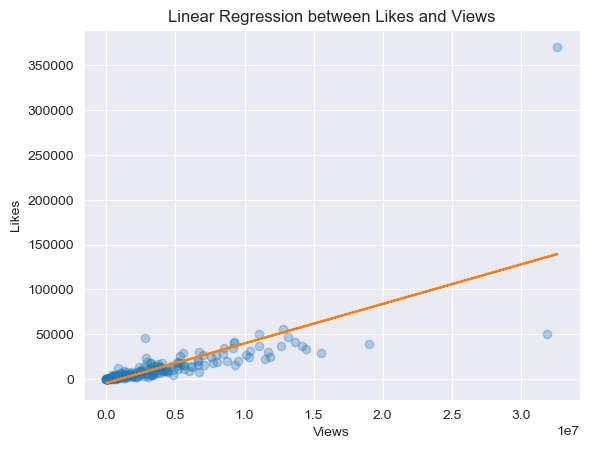

In [272]:
x = df.loc[:, 'Views'].values.reshape(-1,1)
y = df.loc[:, 'Likes'].values.reshape(-1,1)

# Apart from the slope, we are including the intercept in out estimation
x_aug = np.c_[np.ones(len(x)), x]

# We are using the Least Squares method to estimate linear coefficients
beta = np.linalg.lstsq(x_aug, y, rcond=None)[0]

print("Estimated coefficients of the regression line:",
      "\nSlope: ", float('%.*g'% (4, beta[1])),
      "\nIntercept: ", float('%.*g'% (4, beta[0])))

predictions = np.matmul(x_aug, beta)

ax = sns.regplot(x=x, y=y, fit_reg=False, lowess=True, scatter_kws={'alpha':0.3})
ax.set(xlabel = "Views", ylabel = "Likes",
      title = "Linear Regression between Likes and Views")
plt.plot(x, predictions);

In our case the intercept has no interpretation since there isn't a movie with 0 Views (which we are going to check later). However, the slope of the regression line has its meaing; for each increase of 1000 Views, we estimate the number of Likes to go up approximately by 4.4.

In [273]:
print("Coefficient of Determinantion: ", round(r2_score(y_true=y, y_pred=predictions),2))

Coefficient of Determinantion:  0.52


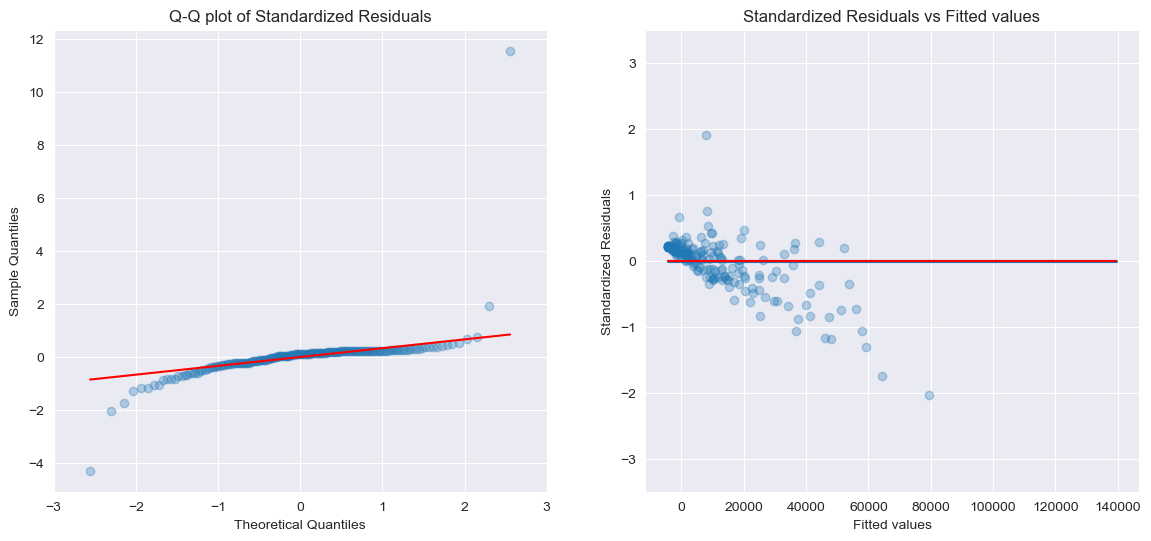

In [274]:
# Q-Q Plot and Standardized residuals plot
residuals = y - predictions
deg_free = len(y) - (1+x.shape[1])

residuals_std = np.sqrt( (1/deg_free) * np.sum(residuals**2) )

leverage = ( (1/len(x))  +  ((x - np.mean(x)**2) / np.sum((x - np.mean(x))**2)) )
standardized_residuals = residuals / (residuals_std * np.sqrt( 1 - leverage))


fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sm.qqplot(np.squeeze(standardized_residuals), scipy.stats.norm,
          line='q', ax=axs[0], alpha=0.3)
#sm.qqplot(np.squeeze(measurements), scipy.stats.norm,
#          line='45', ax=axs[0])
axs[0].set_title(label = 'Q-Q plot of Standardized Residuals')
axs[0].set_xlim(-3,3)

sns.regplot(x=predictions[:,0], 
            y=standardized_residuals, 
            ax=axs[1], 
            scatter_kws={'alpha':0.3},
            ci=None)
plt.plot([min(predictions[:,0]), max(predictions[:,0])], [0, 0], 'r-')
axs[1].set_ylim(-3.5,3.5)
axs[1].set(ylabel='Standardized Residuals', 
           xlabel='Fitted values');
axs[1].set_title(label = 'Standardized Residuals vs Fitted values');

The Q-Q plot indicates that the error terms probably follow a left-skewed normal distribution but we can't see the pattern there clearly due to the scale of the y-axis affected by the outliers. Let's make the plots again, this time igorning the big outliers on the Q-Q plot in order to get a clearer picture for further analysis.

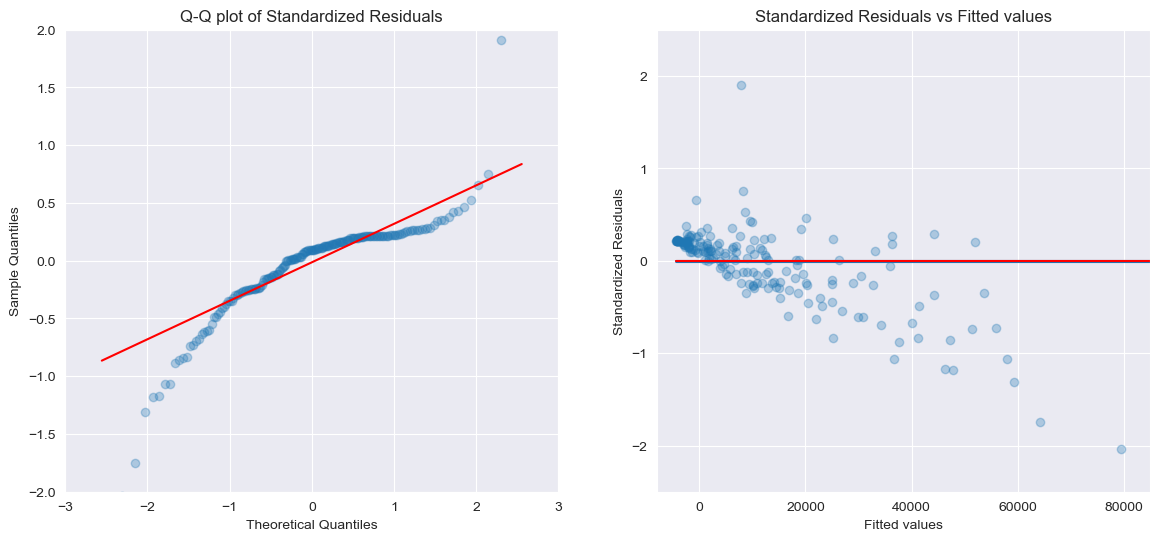

In [275]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sm.qqplot(np.squeeze(standardized_residuals), scipy.stats.norm,
          line='q', ax=axs[0], alpha = 0.3)     # without the np.squeeze() the qqplot function won't sort residuals
axs[0].set_title(label = 'Q-Q plot of Standardized Residuals')
axs[0].set_xlim(-3,3)
#---
axs[0].set_ylim(-2,2)
#---

sns.regplot(x=predictions[:,0], 
            y=standardized_residuals, 
            ax=axs[1], 
            scatter_kws={'alpha':0.3},
            ci=None)
plt.plot([min(predictions[:,0]), max(predictions[:,0])], [0, 0], 'r-')
#---
axs[1].set_xlim(-8000,85000)
axs[1].set_ylim(-2.5,2.5)
#---
axs[1].set(ylabel='Standardized Residuals', 
           xlabel='Fitted values');
axs[1].set_title(label = 'Standardized Residuals vs Fitted values');

The 'Q-Q plot' depicts some deviation from linearity which indicates that the residuals don't follow exactly a normal distribution. However, we can claim that their distribution is similar to normal but with some left-skewness and a shorter right tail.

Another important thing to notice is the accumulation of the points around the median/mean. The residuals may well accumulate more densely around the mean than a normal distribution but we can't conclude it from this Q-Q plot. 

<br/>

Further insights can be provided by looking at the second plot; it should make us suspect the residuals violate the following regression assumptions:
- *Zero Mean Assumption* (Because for very small x-values the residuals are positive and for the larger the x-value, the residuals tend to take more negative values. If this assumption was satisfied, the error terms should oscilate around 0, regardless of x-value)
- *Constant Variance Assumption* (Residual variance increases as the x-values increase, contradicting the assumption that the variance of the error terms is constant)
- *Independence Assumption* (It is violated specifically for the small values of x-axis; we can see there is an aggregation of points with positive value that are close to each other. Therefore, being given a residual, we can predict the vaules of the neighbouring ones. *Independence Assumption* means we shouldn't be able to do that as we assume these values to be independent from each other)

It is also helpful to see the normalized histogram of the standardized_residuals:

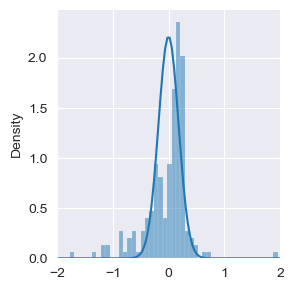

In [276]:
sns.displot(standardized_residuals, bins = 200, stat = 'density', common_norm = True, legend = False, height=3)
plt.xlim(-2,2)

lsp = np.linspace(-2, 2, 100)
n1 = norm.pdf(lsp, loc=0, scale=0.18)
plt.plot(lsp, n1)
plt.show()

On this plot we can see the left-skewness of the residuals more clearly.

#### Applying the log-transformation to the data and evaluating its performance

In [277]:
x_t = np.log(x[x != 0])
y_t = np.log(y[y != 0])

x_t = np.reshape(x_t, (-1, 1))
y_t = np.reshape(y_t, (-1, 1))

Estimated coefficients of the regression line: 
Slope:  0.9665 
Intercept:  -5.394


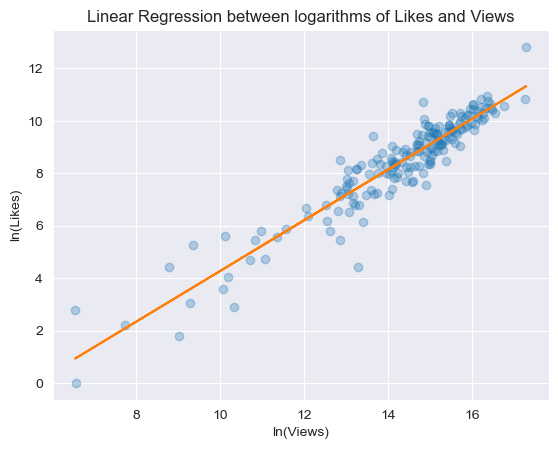

In [278]:
# Linear regression using transformed features

x_t_aug = np.c_[np.ones(len(x_t)), x_t]

# We are using the Least Squares method to estimate linear coefficients
beta_t = np.linalg.lstsq(x_t_aug, y_t, rcond=None)[0]

print("Estimated coefficients of the regression line:",
      "\nSlope: ", float('%.*g'% (4, beta_t[1][0])),
      "\nIntercept: ", float('%.*g'% (4, beta_t[0][0])))

predictions_t = np.matmul(x_t_aug, beta_t)

ax = sns.regplot(x=x_t, y=y_t, fit_reg=False, lowess=True, scatter_kws={'alpha':0.3})
ax.set(xlabel = "ln(Views)", ylabel = "ln(Likes)",
      title = "Linear Regression between logarithms of Likes and Views")
plt.plot(x_t, predictions_t)
plt.show()

We should notice the x-axis of this plot doesn't begin at 0.

In [279]:
print("Coefficient of Determinantion: ", round(r2_score(y_true=y_t, y_pred=predictions_t),2))

Coefficient of Determinantion:  0.89


This value confirms what we can clearly see on the plot; that the Regression Line fits the transformed features much better than the original ones.

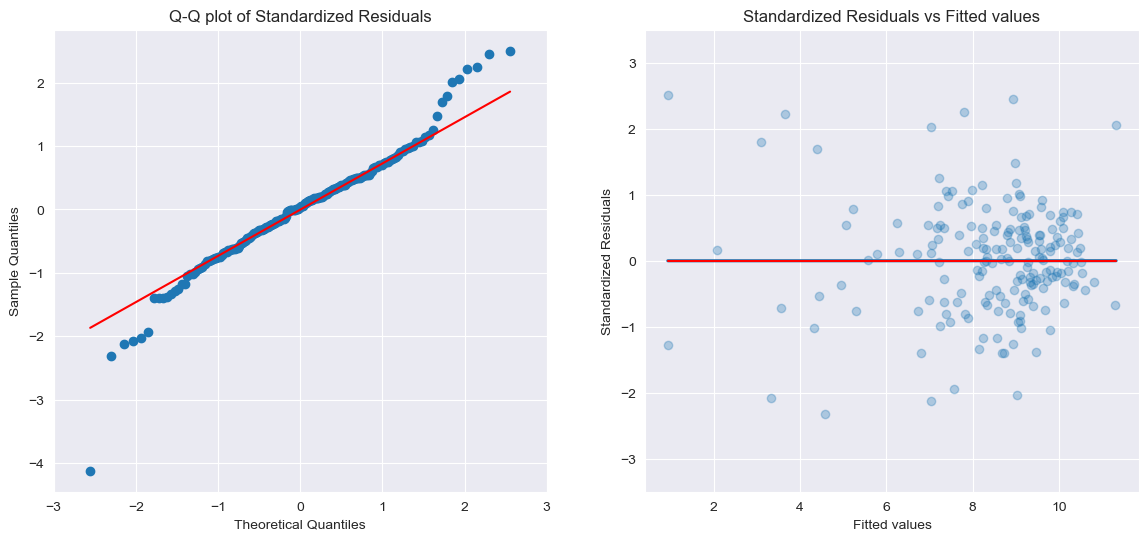

In [280]:
# Q-Q Plot and Standardized residuals plot after transformation

residuals_t = y_t - predictions_t

# degrees of freedom stay the same

residuals_std_t = np.sqrt( (1/deg_free) * np.sum(residuals_t**2) )

leverage_t = ( (1/len(x_t))  +  ((x_t - np.mean(x_t)**2) / np.sum((x_t - np.mean(x_t))**2)) )
standardized_residuals_t = residuals_t / (residuals_std_t * np.sqrt( 1 - leverage_t))

sd_residuals_t = (residuals_t - np.mean(residuals_t)) / np.std(residuals_t)

fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sm.qqplot(np.squeeze(standardized_residuals_t), scipy.stats.norm,
          line='q', ax=axs[0])
axs[0].set_title(label = 'Q-Q plot of Standardized Residuals')
axs[0].set_xlim(-3,3)

sns.regplot(x=predictions_t[:,0], 
            y=standardized_residuals_t, 
            ax=axs[1], 
            scatter_kws={'alpha':0.3},
            ci=None)
plt.plot([min(predictions_t[:,0]), max(predictions_t[:,0])], [0, 0], 'r-')
axs[1].set_ylim(-3.5,3.5)
axs[1].set(ylabel='Standardized Residuals', 
           xlabel='Fitted values');
axs[1].set_title(label = 'Standardized Residuals vs Fitted values');

After applying the log-transformation to the data, the residuals satisfy the regression assumptions significantly better.

From the Q-Q plot we conclude they follow nearly exactly a normal distribution. The only exeption are the tails; the left one is lighter than a normally distributed one and at the right tail there is a slight accumulation of points at some place.


Analysing the remaining assumptions on the second plot:

- *Zero Mean Assumption* may well be satisfied since the residuals from the upper half seem to balance the ones at the bottom

- *Constant Variance Assumption* can also hold but there is a concentration of points of smaller magnitude on the right side of the plot. In order to evaluate if the group of points disturbs the assumption, we should conduct a statitical test.

- *Independence Assumtion*, similarly to the previous one, is better satisfied than in the regression analysis on non-transformed features. However, the concentration of points on the right side probably violates this assumption. With such ambiguities, it would be best to further assess our claims.

The shape of the normalized histogram looks more similar to the normal distribution as well. Therefore we can assume the normality of the residuals is at an acceptable level.

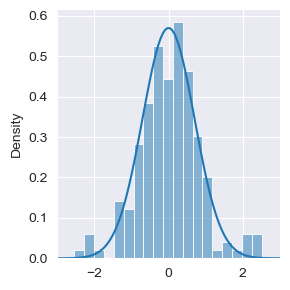

In [281]:
sns.displot(standardized_residuals_t, bins = 25, stat = 'density', common_norm = True, legend = False, height=3)
plt.xlim(-3,3)

lsp = np.linspace(-3, 3, 100)
n1 = norm.pdf(lsp, loc=0, scale=0.7)
plt.plot(lsp, n1)
plt.show()

## Statistical Inference

We are going to perfom the upcoming calculations on the simple linear regression between 'Likes' and 'Views' that we have analysed before.

In [282]:
# For simpler code readibility
from numpy.linalg import inv
from numpy.linalg import det
from numpy import dot

#model = sm.OLS(y, x_aug)
#results = model.fit()

# if you have time you can do it like here https://stackoverflow.com/questions/61292464/get-confidence-interval-from-sklearn-linear-regression-in-python

First we are going to perform the T-test for the linear relationship between the two variables meaning we are going to test the hypothesis $\beta_1 = 0$ against the hypothesis $\beta_1 \neq 0$ (if the slope is equal to 0 there isn't any linear relationship between $x$ and $y$). The confidence level of the testing is 95%.

In [283]:
alpha=0.05

sigma_squared = residuals_std**2

# Calculating the variance and standard error of the coefficients
var_coeff = np.diag(inv(dot(x_aug.T,x_aug))) * sigma_squared
coeff_stde = np.sqrt(var_coeff)

print('Coefficients\' Standard Errors:', coeff_stde)

# T-statistic value
ttest = (beta[1] - 0) / coeff_stde[1]

# P-value of the test
pval = stats.t.sf(np.abs(ttest), deg_free)*2

print('\nTest statistc for the slope estimate: ',ttest,'| P-value:', np.round(pval,8))

Coefficients' Standard Errors: [1.90374535e+03 3.09454257e-04]

Test statistc for the slope estimate:  [14.24032678] | P-value: [0.]


The obtained P-value is clearly smaller than $\alpha=0.05$ so it indicates we should reject the null hypothesis $\beta_1 = 0$. That means there exists a linear relationship between features 'Likes' and 'Views'.

The next step is to construct the confidence interval for the slope of the regression line.

In [284]:
deg_free = (x_aug.shape[0]-x_aug.shape[1])

# Check the values for the Student's T-distribution for 95% confidence interval
t_student_values = stats.t.ppf( [.025,.975], deg_free)

# Computation of the confidence intervals
stde = np.reshape(coeff_stde,(-1,1))
conf_int_coeffs = beta + (t_student_values * stde)

#print("Confidence interval for the intercept: ", conf_int_coeffs[0])

print("Confidence interval for the slope: ", conf_int_coeffs[1])

Confidence interval for the slope:  [0.00379622 0.00501724]


In [285]:
# Correlation coefficient and its 95% confidence interval
corr = stats.pearsonr(x[:,0], y[:,0])

corr_conf_low, corr_conf_high = corr.confidence_interval(confidence_level=0.95)

print("Correlation coefficient between Likes and Views: ", round(corr[0], 3))
print("Its 95% confidence interval: ", [round(corr_conf_low, 3), round(corr_conf_high, 3)])

Correlation coefficient between Likes and Views:  0.723
Its 95% confidence interval:  [0.647, 0.785]


In [286]:
#from statsmodels.stats.outliers_influence import summary_table

result = sm.OLS(y, x_aug).fit()

# x value for which we are going to calculate the confidence interval
fixed_x_num = 160
fixed_x = x[fixed_x_num,0]

mean_y_at_fixed_x = result.predict([1, fixed_x])[0]
print("Mean of y at fixed value of x=",fixed_x, ": ", round(mean_y_at_fixed_x, 2))

# Confidence interval for the mean of y when x value is fixed on fixed_x
pred = result.get_prediction([1, fixed_x])
print("Confidence interval for this mean of y at",fixed_x,": ", pred.conf_int(alpha=0.05)[0])

# Prediction interval for y given x
prediction_int = [mean_y_at_fixed_x - 1.96 * residuals_std, mean_y_at_fixed_x + 1.96 * residuals_std]
print("\nPrediction interval for this mean of y at",fixed_x,": ", prediction_int)
print("Where the actual value of y is:", y[fixed_x_num,0])

Mean of y at fixed value of x= 3920842 :  12947.54
Confidence interval for this mean of y at 3920842 :  [10058.66201289 15836.42576422]

Prediction interval for this mean of y at 3920842 :  [-26299.51577144886, 52194.603548553685]
Where the actual value of y is: 10535


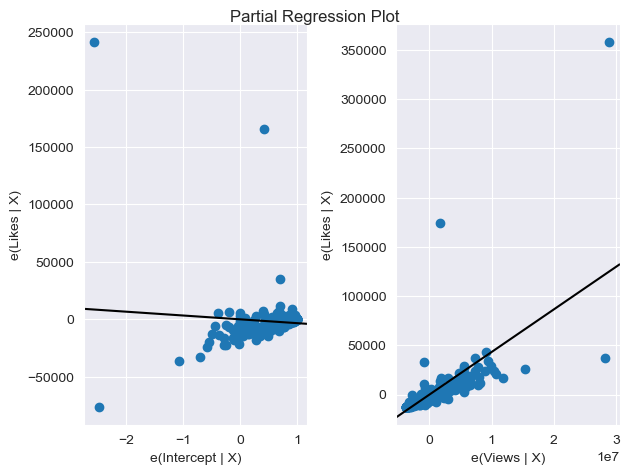

In [287]:
sm.graphics.plot_partregress_grid(results);

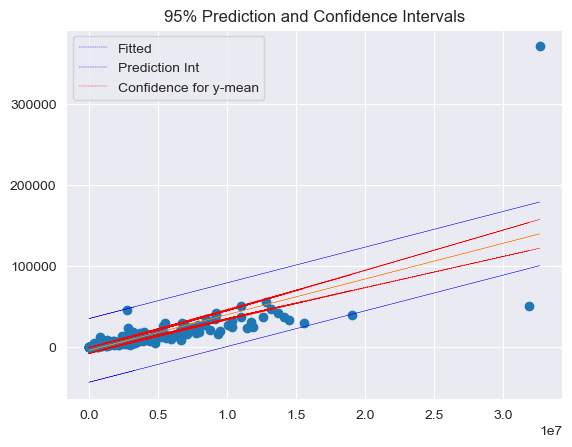

In [288]:
# Confidencde intervals for predicted values of y (mean y) and prediction intervals

pred = result.get_prediction(x_aug)
mean_y_conf_int = pred.conf_int(alpha=0.05)  #based on student's t distribution
#print(mean_y_conf_int[0])

# Prediction intervals
prediction_int = np.c_[predictions[:,0] - 1.96 * residuals_std, predictions[:,0] + 1.96 * residuals_std]
#print(prediction_int)

# Plot of the confidence intervals

plt.plot(x, y, 'o')
plt.plot(x, predictions, '-', lw=0.3)
plt.plot(x, prediction_int[:,0], 'b--', lw=0.3, label="Fitted")
plt.plot(x, prediction_int[:,1], 'b--', lw=0.3, label="Prediction Int")
plt.plot(x, mean_y_conf_int[:,0], 'r--', lw=0.3)
plt.plot(x, mean_y_conf_int[:,1], 'r--', lw=0.3, label="Confidence for y-mean")
plt.title("95% Prediction and Confidence Intervals")
plt.legend()
plt.show()

## Principal Components Analysis

For the PCA we are selecting following attributes: Ratings, Views, Likes, Dislikes, Comments, and Aggregate Followers since each of them reflect how a particular movie was received by the public. They provide information on how much attention did it got and if the viewers were captured by it.

In [289]:
selected_features = ['Ratings', 'Views', 'Likes', 'Dislikes', 'Comments', 'Aggregate Followers']
SF = df[selected_features]

In [290]:
# Centering the data
mean_row = np.mean(SF, axis=0)

# Normalization by ranges
ranges = SF.max(axis=0) - SF.min(axis=0)
SF_range = (SF - mean_row) / ranges

# Normalization by standard deviations
std = SF.std(axis=0)
SF_std = (SF - mean_row) / std

The next step is to obtain the eigenvalues and associated eigenvectors of the covariance matrix. The eigenvectors are the Principal Components onto which we are going to project the space of selected features.

In [291]:
### Range normalization

# Compute the covariance matrix
cov_SF_range = np.cov(SF_range.T)

# Obtain the eigenvalues and eigenvectors and sort them in the descending order
e_r, v_r = np.linalg.eig(cov_SF_range)

order = np.argsort(np.argsort(e_r) * -1)
e_r = e_r[order]
v_r = v_r[:, order]


### Std normalization

# Compute the covariance matrix
cov_SF_std = np.cov(SF_std.T)

# Obtain the eigenvalues and eigenvectors and sort them in the descending order
e_s, v_s = np.linalg.eig(cov_SF_std)

order = np.argsort(np.argsort(e_s) * -1)
e_s = e_s[order]
v_s = v_s[:, order]

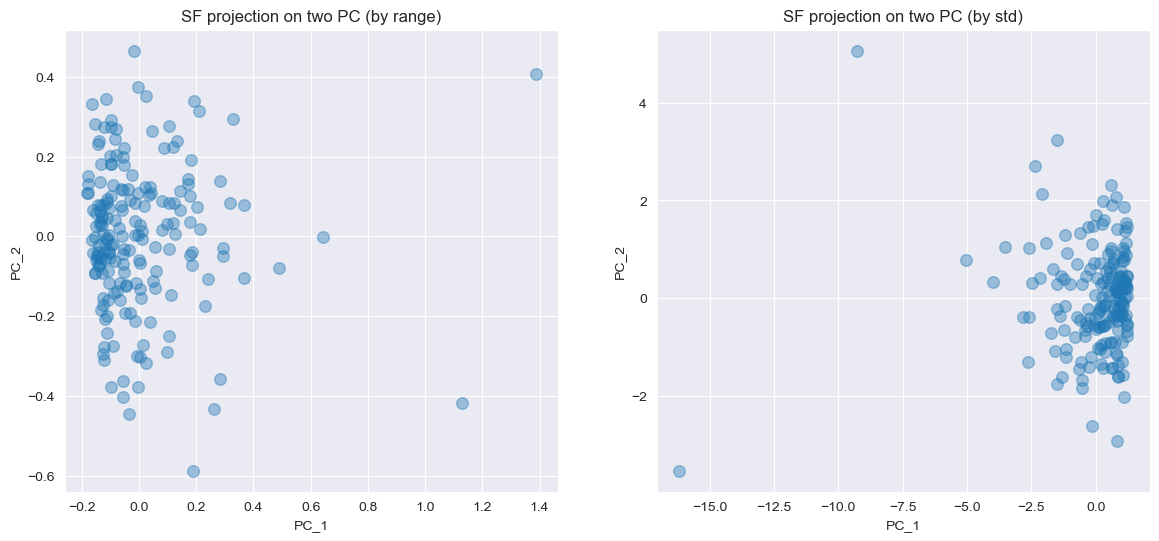

In [292]:
# Project the data

pca_SF_range = np.dot(SF_range, v_r)

pca_SF_std = np.dot(SF_std, v_s)

names = ["PC_" + str(i+1) for i in range(SF.shape[1])]

pca_SF_range = pd.DataFrame(data= pca_SF_range, 
                     columns=names)

pca_SF_std = pd.DataFrame(data= pca_SF_std, 
                     columns=names)


# Plot the projections

fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sns.regplot(x='PC_1',
            y='PC_2',
            data=pca_SF_range,
            fit_reg=False,
            ax=axs[0],
            scatter_kws={'alpha':0.4, "s": 70})
axs[0].set_title(label = 'SF projection on two PC (by range)')

sns.regplot(x='PC_1',
            y='PC_2',
            data=pca_SF_std,
            fit_reg=False,
            ax=axs[1],
            scatter_kws={'alpha':0.4, "s": 70})
axs[1].set_title(label = 'SF projection on two PC (by std)');

Here we can examine the visualizations of the data projected on the first two principal components for the normalization by range as well as by standard deviation. Let's see the 3D visualizations of the projections.

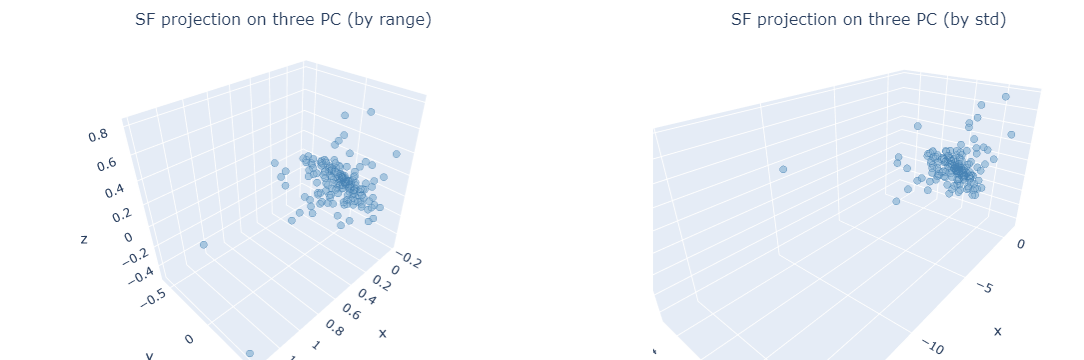

In [293]:
fig_pca = make_subplots(rows=1, cols=2,
                        subplot_titles=["SF projection on three PC (by range)", "SF projection on three PC (by std)"],
                        column_widths=[0.55, 0.45],
                        specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]])

fig_pca.add_trace(go.Scatter3d(x=pca_SF_range['PC_1'],
                               y=pca_SF_range['PC_2'],
                               z=pca_SF_range['PC_3'],
                               mode='markers',
                               marker=dict(color='#98bcd9',
                                           size=4,
                                           opacity=0.8,
                                           line=dict(
                                               color='steelblue',
                                               width=0.1
                                           ))),
                  row=1, col=1)


fig_pca.add_trace(go.Scatter3d(x=pca_SF_std['PC_1'],
                               y=pca_SF_std['PC_2'],
                               z=pca_SF_std['PC_3'],
                               mode='markers',
                               marker=dict(color='#98bcd9',
                                           size=4,
                                           opacity=0.8,
                                           line=dict(
                                               color='steelblue',
                                               width=0.1
                                           ))),
                  row=1, col=2)


fig_pca.update_layout(margin=dict(l=20, r=0, b=0, t=30),
                      showlegend=False)

fig_pca.update_scenes(camera=dict(eye=dict(x=-1.2, y=-1, z=0.8)),
                      row=1, col=2)

Apparently, the points take on the 3D plots take very little space, due to the perspective, which makes these plots less readable than the 2D ones. In this case, the 2D plots seem more intuitive and provide more insight into the data distribution.

### Visualization of the Selected Features using Singular Value Decomposition

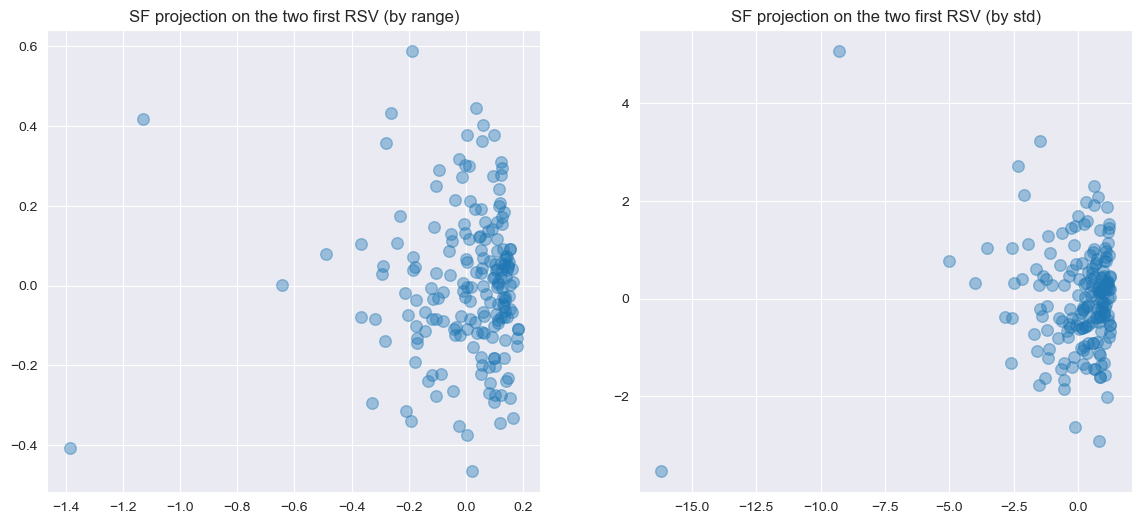

In [294]:
# Calculating the matrices for the range normalization
u_r, s_r, vh_r = np.linalg.svd(SF_range, full_matrices=False)

# We are going to discard the left and right singular vectors corresponding to the value 0
not0 = (s_r != [0])

u_r = (u_r.T[not0]).T
s_r = s_r[not0]
vh_r = (vh_r.T[not0]).T


# Now we are able to project the data onto the space of the right singular vectors

right_SF_range = np.dot(SF_range, vh_r.T)



# Repetaing the process for the std normalization

u_s, s_s, vh_s = np.linalg.svd(SF_std, full_matrices=False)

# We are going to discard the left and right singular vectors corresponding to the value 0
not0 = (s_s != [0])

u_s = (u_s.T[not0]).T
s_s = s_s[not0]
vh_s = (vh_s.T[not0]).T


# Now we are able to project the data onto the space of the right singular vectors

right_SF_std = np.dot(SF_std, vh_s.T)


# Plot the projections

fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sns.regplot(x=right_SF_range[:,0],
            y=right_SF_range[:,1],
            data=right_SF_range,
            fit_reg=False,
            ax=axs[0],
            scatter_kws={'alpha':0.4, "s": 70})
axs[0].set_title(label = 'SF projection on the two first RSV (by range)')

sns.regplot(x=right_SF_std[:,0],
            y=right_SF_std[:,1],
            data=right_SF_std,
            fit_reg=False,
            ax=axs[1],
            scatter_kws={'alpha':0.4, "s": 70})
axs[1].set_title(label = 'SF projection on the two first RSV (by std)');

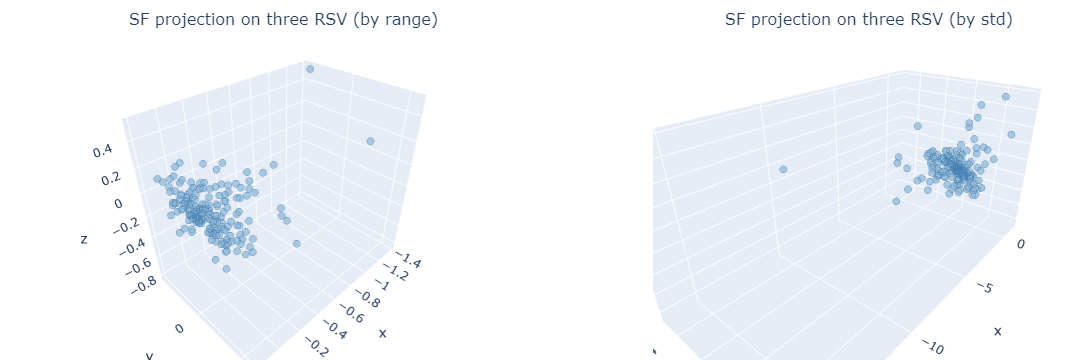

In [295]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=["SF projection on three RSV (by range)", "SF projection on three RSV (by std)"],
                    column_widths=[0.55, 0.45],
                    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]])

fig.add_trace(go.Scatter3d(x=right_SF_range[:,0],
                           y=right_SF_range[:,1],
                           z=right_SF_range[:,2],
                           mode='markers',
                           marker=dict(color='#98bcd9',
                                       size=4,
                                       opacity=0.8,
                                       line=dict(
                                           color='steelblue',
                                           width=0.1
                                       ))),
              row=1, col=1)


fig.add_trace(go.Scatter3d(x=right_SF_std[:,0],
                           y=right_SF_std[:,1],
                           z=right_SF_std[:,2],
                           mode='markers',
                           marker=dict(color='#98bcd9',
                                       size=4,
                                       opacity=0.8,
                                       line=dict(
                                           color='steelblue',
                                           width=0.1
                                       ))),
              row=1, col=2)


fig.update_layout(margin=dict(l=20, r=0, b=0, t=30),
                  showlegend=False)

fig.update_scenes(camera=dict(eye=dict(x=-1.2, y=-1, z=0.8)),
                  row=1, col=2)


In every pair of plots above, for PCA as well as for SVD, we can see the normalization by range does a better job in reducing the data magnitude because the points don't overlap with each other so much as if we normalize by standard deviation. Although the absolute values of the coordinates are higher when we normalize by std, this method of scaling seems to have squished our data too much, making it impossible to see what is happening in the area where points accumulate.

The reason why the normalization by range works better could be that some features have a different magnitute than the others (for example compare Ratings with Views or Aggregate Followers) so, when projecting onto the orthogonal base, some coordinates should still remain bigger than the others. Especially because such projection corresponds to the rotation of the space. Range normalization solves this problem by rescaling each feature to the interval [0,1] so that both ends are attained by some points. Also, it's worth to mention we don't have any heavy outlier among the selected features since otherwise range normaliztion would squish the remaining points together to a very small interval (that rescaling would happen of course along the feature we observe the big differences in). Then, the normalization by std would be a better option as it's less sensitive to outliers but, having in mind our data, it isn't the case and the differeces in magnitudes play much more significant role.

The visualizations obtain by PCA and SVD look very similar to each other. Let's examine it with a side-by-side 2D plots where the x-axis and y-axis of the SVD are flipped.

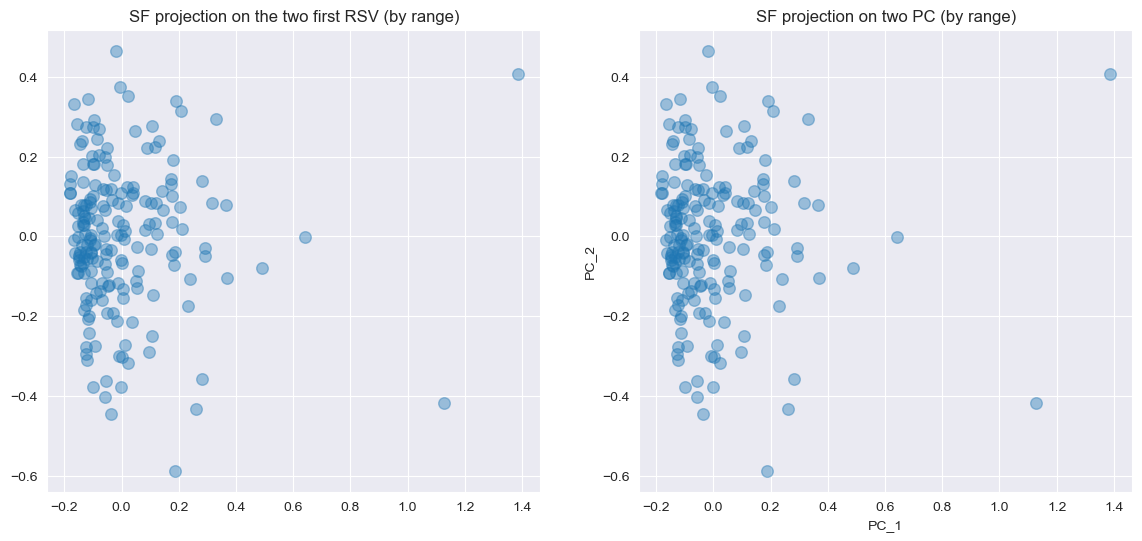

In [296]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))

sns.regplot(x='PC_1',
            y='PC_2',
            data=pca_SF_range,
            fit_reg=False,
            ax=axs[1],
            scatter_kws={'alpha':0.4, "s": 70})
axs[1].set_title(label = 'SF projection on two PC (by range)');

sns.regplot(x=-right_SF_range[:,0],
            y=-right_SF_range[:,1],
            data=right_SF_range,
            fit_reg=False,
            ax=axs[0],
            scatter_kws={'alpha':0.4, "s": 70})
axs[0].set_title(label = 'SF projection on the two first RSV (by range)');

In [297]:
pd.DataFrame(round(pca_SF_range - (-right_SF_range), 3).max(), columns= ['Diff PCA and -SVD']).T

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
Diff PCA and -SVD,-0.0,0.0,0.0,1.253,0.282,0.0


Examining the differences between projections confirms our observation; for the first three principal components/right singular vectors the visualizations are essentially the same. Let's proceed further with the PCA projections.

We are going to see now if there is any visible group on our visualizations regarding the genre. If so that could give us a clue that there is a relationship between selected features and a genre of the movie.

In [298]:
# Adding a target genre to our dataframes of PCA projections

pca_SF_range = pd.concat([pca_SF_range, df['Genre']], axis=1)

pca_SF_std = pd.concat([pca_SF_std, df['Genre']], axis=1)

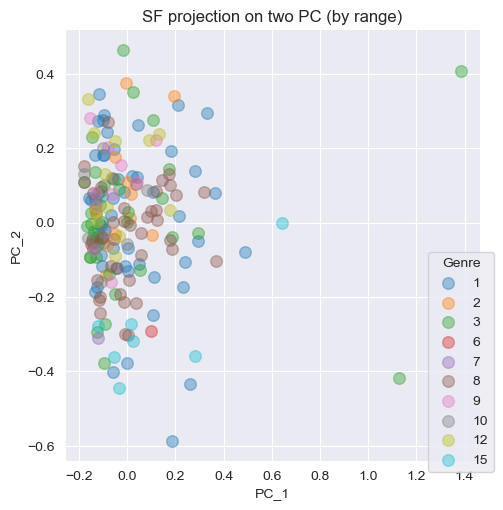

In [299]:
ax = sns.lmplot(x='PC_1',
                y='PC_2',
               data=pca_SF_range,
               hue='Genre',   #.astype('category').apply(lambda x: sns_colors[x]),
               fit_reg=False,
               scatter_kws={'alpha':0.4, "s": 70},
               facet_kws=dict(legend_out=False))
plt.title('SF projection on two PC (by range)')
plt.legend(bbox_to_anchor=(1.05, 0.5), title='Genre');  # add labels = data.target_names if we have info about the genres

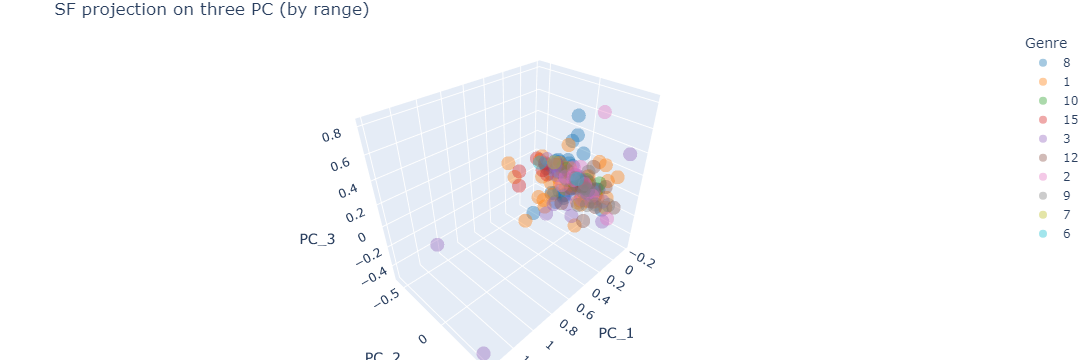

In [300]:
color_list = [f"rgb({int(r * 255)},{int(g * 255)},{int(b * 255)})" for r, g, b in sns.color_palette()]
#sns_colors = {genre: color_list[i] for i, genre in enumerate(df["Genre"].unique())}

fig = px.scatter_3d(data_frame=pca_SF_range, x='PC_1', y='PC_2', z='PC_3',
                    color=pca_SF_range['Genre'].astype('category'), color_discrete_sequence=color_list,
                    opacity=0.4, size_max=3,
                    labels={'color': 'Genre'}
                    
                   )

fig.update_layout(margin=dict(l=30, r=0, b=0, t=30),
                  title="SF projection on three PC (by range)")

fig.show()

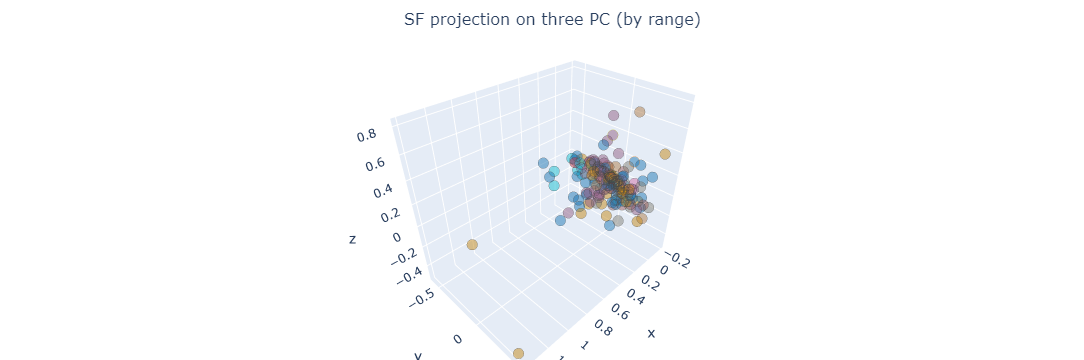

In [301]:
# Making the plots with genres

fig = make_subplots(rows=1, cols=1,
                    subplot_titles=["SF projection on three PC (by range)"],
                    specs=[[{"type": "scatter3d"}]])


fig.add_trace(go.Scatter3d(x=pca_SF_range['PC_1'],
                           y=pca_SF_range['PC_2'],
                           z=pca_SF_range['PC_3'],
                           mode='markers',
                           showlegend=True,
                           marker=dict(color=pca_SF_range['Genre'].astype('category'),
                                       colorscale=color_list,
                                       size=6,
                                       opacity=0.5,
                                       line=dict(
                                           color=sns.color_palette(),
                                           width=0.1
                                       ))),
              row=1, col=1)

fig.update_layout(margin=dict(l=20, r=0, b=0, t=30),
                  showlegend=False)

#### Evaluating the PCA projections

We will present below a short summary of the PCA projections containing the proportion of variance captured by each principal component, its cumulative sum and the eigenvalues.

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
Cumulative sum,0.366371,0.690101,0.926596,0.974755,0.994241,1.000000
Proportion of Variance,0.366371,0.323730,0.236496,0.048159,0.019485,0.005759
Eigenvalue,0.037297,0.032956,0.024075,0.004903,0.001984,0.000586


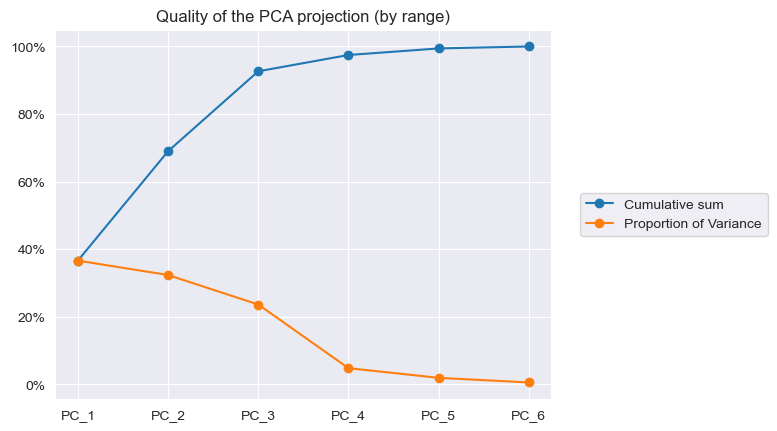

In [302]:
# Calculate the proportion of explained variance by each principal component of the range normalization
ratio_r = e_r / np.sum(e_r)

# Creating the summary
pca_summary_r = pd.DataFrame({"Cumulative sum": np.cumsum(ratio_r),
                            "Proportion of Variance": ratio_r,
                            "Eigenvalue": e_r},
                           index = names)

display(pca_summary_r.T)


ax = pca_summary_r.iloc[:,:2].plot(marker='o')

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.legend(bbox_to_anchor=(1.45, 0.5), loc='center right')

ax.set_title("Quality of the PCA projection (by range)");

In order to compare the normalization by range to the one by standard deviation, we will create a summary for the second option as well.

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
Cumulative sum,0.51912,0.711766,0.873704,0.962353,0.986267,1.000000
Proportion of Variance,0.51912,0.192646,0.161938,0.088649,0.023914,0.013733
Eigenvalue,3.11472,1.155873,0.971628,0.531895,0.143486,0.082398


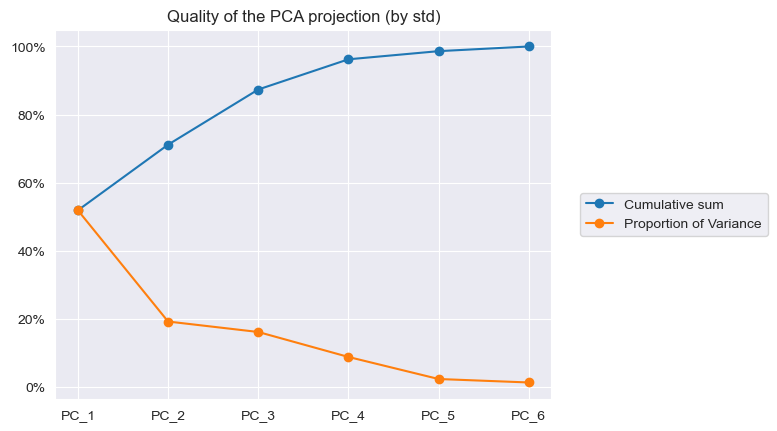

In [303]:
# Calculate the proportion of explained variance by each principal component of the std normalization
ratio_s = e_s / np.sum(e_s)

# Creating the summary
pca_summary_s = pd.DataFrame({"Cumulative sum": np.cumsum(ratio_s),
                            "Proportion of Variance": ratio_s,
                            "Eigenvalue": e_s},
                           index = names)

display(pca_summary_s.T)

ax = pca_summary_s.iloc[:,:2].plot(marker='o')

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.legend(bbox_to_anchor=(1.45, 0.5), loc='center right')

ax.set_title("Quality of the PCA projection (by std)");


In both cases the 3D visualizations consisting of the first three Principal Components should be enough to capture the essential information of the data as they retain around 90% of the total variance. When we look carefully at the cumulative sum values, we can see the 3D visualization by range is silghtly better, with a proportion of explained variance over 90%, when the std normalization attains a level close but below 90% which is ofter considered a good threshold.

When it comes to the 2D projections, their quality is basically the same for each normalization, maybe with a marginal advantage of the std. However, we have examined before that scaling by standard deviation resulted in our projections being more clustered which can make the plot less readable. That is why choosing the range normalization is a more reasonable choice in this case.

To summarize, the go-to PCA visualizations that bring the most clarity for the viewer appear to be the 2D and 3D ones obtained from the normalization by range.

## Fuzzy Clustering with Anomalous Patterns

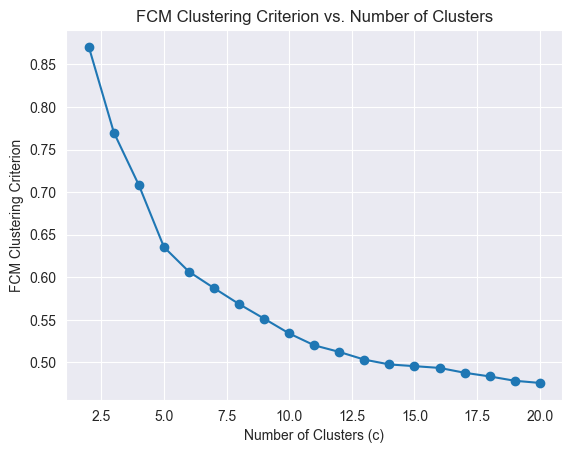

In [6]:

import skfuzzy as fuzz
from skfuzzy.cluster import cmeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('CSM dataset.csv', sep=';', decimal=',')
df.dropna(axis=0, inplace = True)
df.reset_index(drop=True, inplace=True)
# Remove non-numeric columns
df = df.drop(columns=['Movie', 'Year', 'Genre'])

# Define the range of c values to test
c_min = 2
c_max = 20
c_values = range(c_min, c_max + 1)

# Initialize empty lists to store FCM clustering criterion
fcm_criterion = []


# Perform fuzzy c-means clustering for different values of c
for c, c_value in enumerate(c_values, start=2):
    criterion_values = []
    for i in range(100):  # Perform 100 initializations
        seeds = np.random.randint(0, 1000, size=100)  # Generate 100 random seeds
        # Perform fuzzy c-means clustering
        cntr, u, u0, d, jm, p, fpc = cmeans(df.values.T, c_value, m=2, error=0.01, maxiter=100, seed=seeds[i])
        # Append FCM clustering criterion to the list
        

        criterion_values.append(fpc)
    # Take the mean of FCM clustering criterion from different initializations
    fcm_criterion.append(np.mean(criterion_values))
    
# Plot FCM clustering criterion against different values of c
plt.plot(c_values, fcm_criterion, marker='o')
plt.xlabel('Number of Clusters (c)')
plt.ylabel('FCM Clustering Criterion')
plt.title('FCM Clustering Criterion vs. Number of Clusters')
plt.grid(True)
plt.show()


We can observe that the larger the number of clusters, the lower the value of the FCM criterion. This function decreases exponentially.  This is due to the fact that as we increase the number of clusters, each data point tends to have a closer centroid, resulting in a smaller overall cost function. The values of FCM Criterion have no bigger differences after around c=10. After value c=6 the fuction starts to flatten out. We can approximate the value to be c=5, because it stands out the most and it almost creates an angle. 

### Iterative Anomalous Pattern (IAP) clustering algorithm

187


C:\Users\Kinga\AppData\Local\Temp\ipykernel_11360\3250715600.py:240: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', cmap='hot')


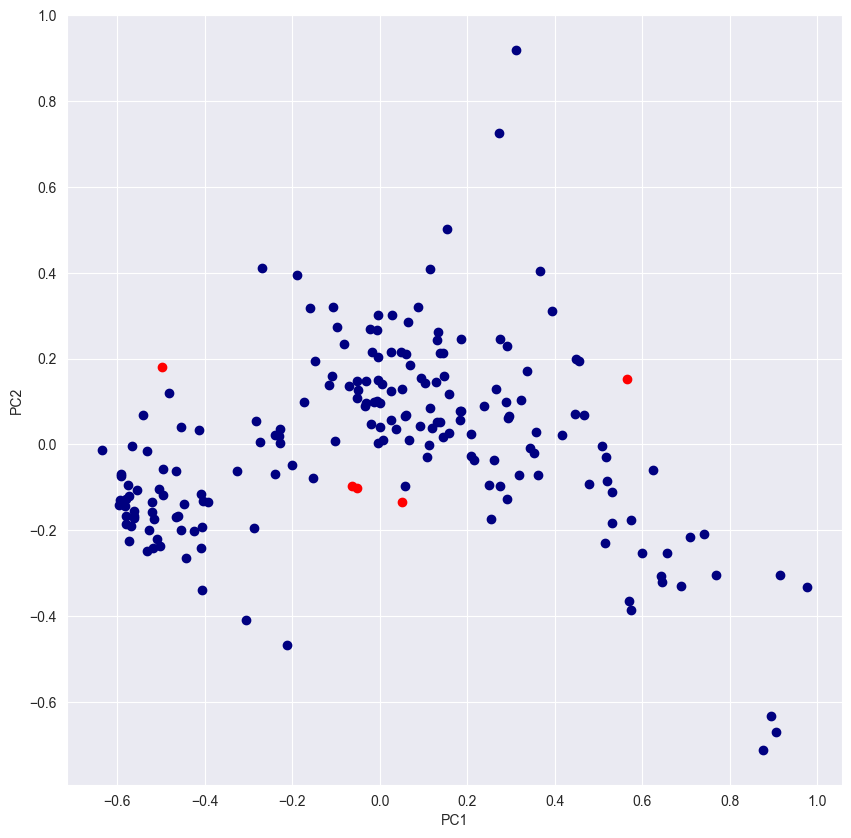

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


normalization = 0# normalization FLAG

#normalization
scaler = MinMaxScaler() 
df_norm = scaler.fit_transform(df)
df_norm_df = pd.DataFrame(df_norm, columns=df.columns, index=df.index)



#code from profesor's tutorial with some changes

## Anomalous Pattern Algorithm

def center_(x, cluster):
    """ 
    calculates the centroid of the cluster
    x - the original data matrix ( N x d)
    cluster - the set with indices (i= 1, 2, ..., N) of the objects belonging to the cluster
    returns the centroid of the cluster 
    """
    #number of columns
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []
        for i in cluster:
            zc.append(zz[i])
        centroidC.append(np.mean(zc))
    return centroidC


def distNorm(x ,remains, ranges, p):
    """ 
     Finds the normalized distances of data points in 'remains' to reference point 'p' 
     x - the original data matrix ( N x d)
     remains- the set of X-row indices: the indices of the entities under consideration
     ranges- the vector with the ranges of the data features  
     p - the reference data point the distances relate to
     distan- returns the column vetor  with the distances from p to remains 
     """

    
    mm = x.shape[1]      # number of data features
    rr = len(remains)    # number of entities in remains    
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))     # Construct an array by repeating input array np.array(p)  
                                           # the number of times given by (rr, 1)
    
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    distan = di
    return distan


def separCluster(x0, remains, ranges, a, b):
    """  
    Builds a cluster by splitting the points around the reference point 'a' from those around the reference point b 
    x0 - data matrix
    remains- the set of X-row indices: the indices of the entities under consideration
    ranges-  the vector with the ranges of the data features  
    a, b - the reference points
    cluster - returns a set with row indices of the objects belonging to the cluster  
    """
    
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)
    clus = np.where(dista < distb)[0]
    cluster = []
    for i in clus:
        cluster.append(remains[i])
    return cluster


 ## Consult description of building an Anomalous cluster (lecture T3 - slide #57)
def anomalousPattern(x, remains, ranges, centroid, me):
    """ Builds one anomalous cluster based on the algorithm 'Separate/Conquer' (B. Mirkin (1999): Machine Learning Journal) 
        x - data matrix,
        remains - the set of X-row indices: the indices of the entities under consideration
        ranges - normalizing values: the vector with ranges of data features  
        centroid - initial center of the anomalous cluster being build
        me - vector to shift the 0 (origin) to
        Returns a tuple with:
                cluster - set of (remains) row indices in the anomalous cluster, 
                centroid - center of the built anomalous cluster    
    """        
    key = 1
    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
          
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0
    return (cluster, centroid)

def dist(x, remains, ranges, p):
    """ 
      Calculates the normalized distances of data points in 'remains' to reference point 'p'   
       x - data matrix,
       remains - the set of X-row indices: the indices of the entities under consideration
       ranges - normalizing values: the vector with ranges of data features      
       distan - returns the calculated normalized distances
    """

    
    mm = x.shape[1]       #number of columns
    rr = len(remains)     # number of entities in remains  
    distan = np.zeros((rr,1))    
    for j in range(mm):
        z = x[:, j]         # j feature vector
        z = z.reshape((-1,1))
        zz = z[remains]
        y = zz - p[j]
        y = y / ranges[j]
        y = np.array(y)
        yy = y * y
        distan = distan + yy
    return distan
def AnomP(normalization, threshold, dataframe):
    x = dataframe.values.astype(np.float32)
    #y = data.target

    #number of data points
    nn = x.shape[0]
    #number of features
    mm = x.shape[1]

    # grand means
    me = []
    # maximum value
    mmax = []
    # minimum value
    mmin = []
    # ranges
    ranges = []
    # "anomalous cluster" ancl is the data structure to keep everything together
    ancl = []
    cluster_list = []
    centroid_list = []
    dD_list = []


    for j in range(mm): # for each feature
        z = x[:, j]     # data column vector j-th feature
        me.append(np.mean(z))
        mmax.append(np.max(z))
        mmin.append(np.min(z))
        if normalization:
            ranges.append(1);
        else:
            ranges.append(mmax[j] - mmin[j])
        if ranges[j] == 0:
            print("Variable num {} is contant!".format(j))
            ranges[j] = 1
        
    sy = np.divide((x - me), ranges)
    sY = np.array(sy)
    d = np.sum(sY * sY)   # total data scatter of normalized data


    # x, me range, d
    remains = list(range(nn))
    numberC = 0

    while len(remains) != 0:
        distance = dist(x, remains, ranges, me)
        ind = np.argmax(distance)
        index = remains[ind]
        centroid = x[index, :]
        numberC = numberC + 1
        
        (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me)
        
        censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges))
        dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d))

        remains = np.setdiff1d(remains, cluster)
        
        cluster_list.append(cluster)
        centroid_list.append(censtand)
        dD_list.append(dD)

    # Convert to DataFrame
    df_ancl = pd.DataFrame({'Cluster': cluster_list, 'Centroid': centroid_list, 'Data Scatter Proportion': dD_list})

    cent = np.zeros((numberC, len(dataframe.columns)))

    for ik in range(numberC):
        cluster = cluster_list[ik]
        if len(cluster) >= threshold:
            cent[ik] = np.mean(dataframe.values[cluster], axis=0)
            
    num_cents = np.sum(np.sum(cent, axis=1) != 0)
    cent = cent[:num_cents]
    
    init_partition = np.zeros((dataframe.shape[0], num_cents))
 
    for index, row in enumerate(dataframe.values):
        d = list(row)
        dists = [np.linalg.norm(d - c) for c in cent]
        assign = dists.index(np.min(dists))
        init_partition[index, assign] = 1
        
    return [num_cents, np.round(cent, 2), init_partition]  

threshold = 5
anom_p_result = AnomP(normalization=0, threshold=threshold, dataframe=df_norm_df)

#applying fuzzy-c-menas
ap_fcm_result = cmeans(df_norm.T, anom_p_result[0], m=2, error=0.001, maxiter=100, init = anom_p_result[2].transpose())

#PCA 
#perform PCA on result
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_norm_df)
print(len(pca_result))

#PCA on cluster centers
pca_centers = pca.fit_transform(ap_fcm_result[0])


fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(111)
axis.scatter(pca_result[:, 0], pca_result[:, 1], c='navy')
axis.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', cmap='hot')

axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)

plt.show()


C:\Users\Kinga\AppData\Local\Temp\ipykernel_11360\3239509275.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis.scatter(pca_result[:, 0], pca_result[:, 1], c=principalDF['color'], cmap='crest')
C:\Users\Kinga\AppData\Local\Temp\ipykernel_11360\3239509275.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis.scatter(pca_centers[:, 0], pca_centers[:, 1], c=principalcluster['color'], cmap='hot')


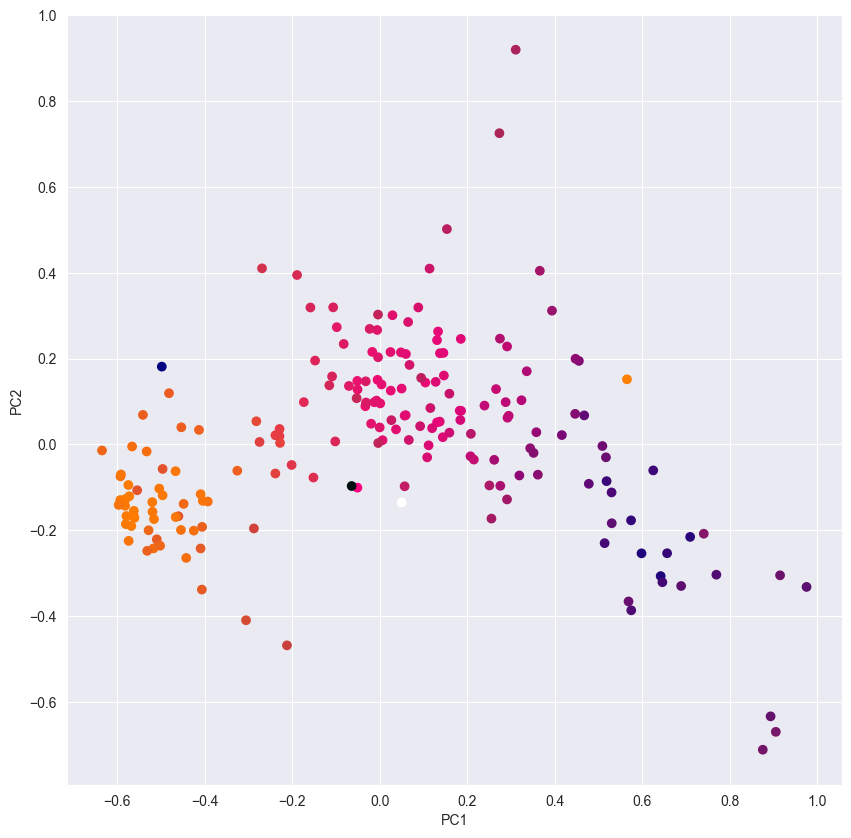

In [10]:
import matplotlib.colors

def combine_hex_values(d):
    d_items = sorted(d.items())
    tot_weight = sum(d.values())
    red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
    green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
    blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
    zpad = lambda x: x if len(x)==2 else '0' + x
    return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])

principalcluster = pd.DataFrame(data=pca_centers)
principalcluster['color'] = ['#ff7f00', '#ff007f', '#000080', '#000f0f', '#ffffff']  # zmieniono kolor zielony na różowy

principalDF = pd.DataFrame(data=pca_result)

# Calculate FCM colors
scatter_colors = []
for row in ap_fcm_result[1].T:
    color_map = {"ff7f00": row[0], "ff007f": row[1], "000080": row[2]}  # zmieniono kolor zielony na różowy
    target_color = combine_hex_values(color_map)
    scatter_colors.append('#' + target_color)

# Assign FCM colors
principalDF['color'] = scatter_colors

# Plotting
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(111)
axis.scatter(pca_result[:, 0], pca_result[:, 1], c=principalDF['color'], cmap='crest')
axis.scatter(pca_centers[:, 0], pca_centers[:, 1], c=principalcluster['color'], cmap='hot')

axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)

plt.show()


The threshold parameter represents the minimum cardinality required for a cluster to be classified as anomalous. So it sets the minimum number of data points needed for a cluster to be considered significant enough to be flagged as anomalous.

With threshold 1 we have 12 clusters. 
With threshold 2 we have 7 clusters.
With threshold 3 we have 6 clusters.
With threshold 4 we have 6 clusters.
With threshold 5-15 we have 5 clusters.
With threshold 16-25 we have 3 clusters.
With threshold 26-35 we have 3 clusters but with diferent position.
With threshold 36-48 we have 1 cluster.
With threshold >48 the algorythm is not working.

Having 1 cluster with threshold <36-48> suggests that the algorithm has identified a major trend or anomaly in the data that requires a larger number of data points to form a cluster. With threshold > 48 the fuction is not working and makes an error. It shows that the stringency level has become too high, due to insufficient data points to form the required number of clusters, causing the algorithm to fail. Lower thresholds lead to finer-grained clustering, capturing smaller variations in the data and identifying more clusters, while higher thresholds result in coarser clustering, highlighting only the major trends or anomalies


#### Applying validation indices - Partition Coefficient and Xie-Beni index

Partition Coefficient and Xie-Beni index for  Anomalous Patterns FCM

In [12]:
import numpy as np
from sklearn.metrics import pairwise_distances

# Calculate intra-cluster distances
def calculate_intra_cluster_distances(data_matrix, cluster_membership, cluster_centers):
    intra_cluster_distances = []
    for cluster_index in range(cluster_membership.shape[1]):
        cluster_indices = np.where(cluster_membership[:, cluster_index] == 1)[0]
        if len(cluster_indices) == 0:
            continue  # Skip empty clusters
        centroid = np.mean(data_matrix[cluster_indices], axis=0)
        intra_dist = np.sum(np.linalg.norm(data_matrix[cluster_indices] - centroid, axis=1))
        intra_cluster_distances.append(intra_dist)
    return intra_cluster_distances

# Calculate Partition Coefficient
def calculate_partition_coefficient(intra_cluster_distances, sum_all_distances):
    if sum_all_distances != 0:
        pc = np.sum(intra_cluster_distances) / sum_all_distances
    else:
        pc = np.nan  # Assign NaN if sum_all_distances is zero
    return pc

# Calculate Xie-Beni index
def calculate_xie_beni(data_matrix, cluster_centers, membership_matrix):
    squared_distances = np.sum((data_matrix[:, np.newaxis] - cluster_centers) ** 2, axis=2)
    weighted_distances = squared_distances * (membership_matrix.T ** 2)  # Transpose membership_matrix
    cluster_sizes = np.sum(membership_matrix, axis=0)
    xie_beni = np.sum(weighted_distances) / (data_matrix.shape[0] * np.sum(cluster_sizes))
    return xie_beni

# Calculate intra-cluster distances
intra_cluster_distances = calculate_intra_cluster_distances(df_norm_df.values.astype(np.float64), ap_fcm_result[2].T, ap_fcm_result[0])

# Calculate the sum of all distances
all_distances = pairwise_distances(df_norm_df.values.astype(np.float64))
sum_all_distances = np.sum(all_distances)

# Calculate Partition Coefficient
pc = calculate_partition_coefficient(intra_cluster_distances, sum_all_distances)

# Calculate Xie-Beni index
xb_index = calculate_xie_beni(df_norm_df.values.astype(np.float64), ap_fcm_result[0], ap_fcm_result[1])

print("Partition Coefficient (PC):", pc)
print("Xie-Beni index:", xb_index)


Partition Coefficient (PC): 0.0031252607497117817
Xie-Beni index: 0.0002932898732559319


Partition Coefficient and Xie-Beni index for fuzzy c-partitions

In [13]:
from sklearn.metrics import pairwise_distances

# Initialize empty lists to store Xie-Beni index and Partition Coefficient
xb_index_values = []
pc_values = []

# Perform fuzzy c-means clustering for different values of c
for c_value in c_values:
    criterion_values = []
    for i in range(100):  # Perform 100 initializations
        seeds = np.random.randint(0, 1000, size=100)  # Generate 100 random seeds
        # Perform fuzzy c-means clustering
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            df_norm_df.values.T, c_value, m=2, error=0.01, maxiter=100, seed=seeds[i])
        # Calculate membership matrix
        membership_matrix = u
        # Calculate cluster centers
        cluster_centers = cntr
        # Calculate intra-cluster distances
        intra_cluster_distances = []
        for cluster_index in range(c_value):  
            cluster_indices = np.where(membership_matrix.argmax(axis=0) == cluster_index)[0] 
            if len(cluster_indices) == 0:
                intra_cluster_distances.append(np.nan)
                continue
            centroid = np.mean(df_norm_df.values[cluster_indices], axis=0)  
            intra_dist = np.sum(np.linalg.norm(df_norm_df.values[cluster_indices] - centroid, axis=1))  
            intra_cluster_distances.append(intra_dist)
        # Calculate the sum of all distances
        all_distances = pairwise_distances(df_norm_df.values)
        sum_all_distances = np.sum(all_distances)
        # Calculate Partition Coefficient
        if sum_all_distances != 0:
            pc = np.sum(intra_cluster_distances) / sum_all_distances
        else:
            pc = np.nan  # Assign NaN if sum_all_distances is zero
        pc_values.append(pc)
        # Calculate Xie-Beni index
        numerator = np.sum(intra_cluster_distances)
        if fpc * sum_all_distances != 0:
            xb_index = numerator / (fpc * sum_all_distances)
        else:
            xb_index = np.nan  # Assign NaN if denominator is zero
        xb_index_values.append(xb_index)
        
# Print Xie-Beni index and Partition Coefficient for each c value
for c_value, xb_index, pc in zip(c_values, xb_index_values, pc_values):
    print(f"Number of Clusters (c): {c_value}, Xie-Beni Index: {xb_index}, Partition Coefficient: {pc}")



Number of Clusters (c): 2, Xie-Beni Index: 0.004443030754982446, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 3, Xie-Beni Index: 0.004442972736480101, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 4, Xie-Beni Index: 0.004443241852823381, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 5, Xie-Beni Index: 0.004443048911398158, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 6, Xie-Beni Index: 0.004443179352877803, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 7, Xie-Beni Index: 0.004443009283148201, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 8, Xie-Beni Index: 0.004442860398397866, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 9, Xie-Beni Index: 0.0044431102946131265, Partition Coefficient: 0.002965373457810803
Number of Clusters (c): 10, Xie-Beni Index: 0.004442748945285978, Partition Coefficient: 0.002965373457810803
Number of Cluster

The Xie-Beni Index and Partition Coefficient remain relatively stable across different numbers of clusters. This suggests that the dataset may not exhibit clear boundaries between clusters, and adding more clusters does not significantly improve the overall clustering quality.
It seems that the optimal number of clusters may not be clearly defined. 
The Xie-Beni Index and Partition Coefficient do not exhibit significant changes as the number of clusters increases, indicating that the dataset may not naturally lend itself to a specific number of clusters. There is also possibility that we did somethnig wrong what may influence the results.